# gpOptimizer Single-Task Test

This is the new test for fvgp version 4.0.0 and later.

In [1]:
##first install the newest version of fvgp
#!pip install gpcam==?.?.?

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gpcam import GPOptimizer
import time


%load_ext autoreload
%autoreload 2

In [3]:
from itertools import product
x_pred1D = np.linspace(0,1,1000).reshape(-1,1)

## Data

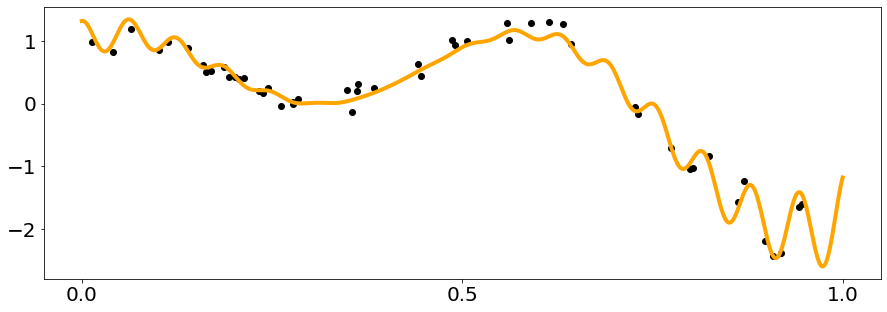

In [4]:
x = np.linspace(0,600,1000)
def f1(x):
    return np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)
 
x_data = np.random.rand(50) 
y_data = f1(x_data) + (np.random.rand(len(x_data))-0.5) * 0.5

plt.figure(figsize = (15,5))
plt.xticks([0.,0.5,1.0])
plt.yticks([-2,-1,0.,1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(x_pred1D,f1(x_pred1D), color = 'orange', linewidth = 4)
plt.scatter(x_data,y_data, color = 'black')

## Customizing a Gaussian Process

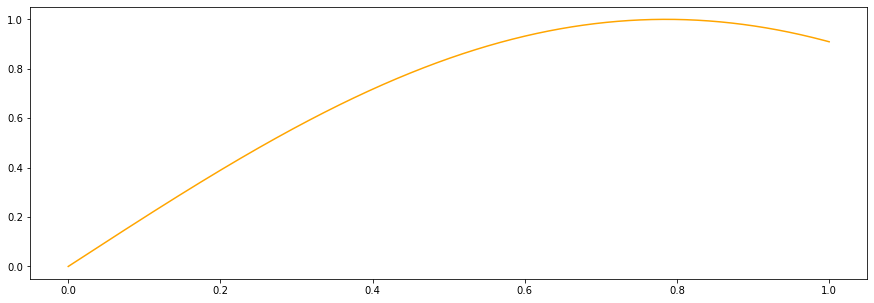

In [5]:
def my_noise(x,hps,obj):
    #This is a simple noise function, but can be arbitrarily complex using many hyperparameters.
    #The noise function always has to return a matrix, because the noise can have covariances.
    return np.diag(np.zeros((len(x))) + hps[2])

#stationary
def skernel(x1,x2,hps,obj):
    #The kernel follows the mathematical definition of a kernel. This
    #means there is no limit to the variety of kernels you can define.
    d = obj._get_distance_matrix(x1,x2)
    return hps[0] * obj.matern_kernel_diff1(d,hps[1])


def meanf(x, hps, obj):
    #This ios a simple mean function but it can be arbitrarily complex using many hyperparameters.
    return np.sin(hps[3] * x[:,0])
#it is a good idea to plot the prior mean function to make sure we did not mess up
plt.figure(figsize = (15,5))
plt.plot(x_pred1D,meanf(x_pred1D, np.array([1.,1.,5.0,2.]), None), color = 'orange', label = 'task1')

## Initialization and different training options

In [6]:
my_gpo = GPOptimizer(x_data,y_data,
            init_hyperparameters = np.ones((4))/10.,  # we need enough of those for kernel, noise and prior mean functions
            noise_variances=np.ones(y_data.shape) * 0.01, #provding noise variances and a noise function will raise a warning 
            compute_device='cpu', 
            gp_kernel_function=skernel, 
            gp_kernel_function_grad=None, 
            gp_mean_function=meanf, 
            gp_mean_function_grad=None,
            gp_noise_function=my_noise,
            normalize_y=False,
            sparse_mode=False,
            gp2Scale = False,
            store_inv=False, 
            ram_economy=False, 
            args=None,
            )


hps_bounds = np.array([[0.01,10.], #signal variance for the kernel
                       [0.01,10.], #length scale for the kernel
                       [0.001,0.1],  #noise
                       [0.01,1.]  #mean
                      ])

my_gpo.tell(x_data, y_data, noise_variances=np.ones(y_data.shape) * 0.01)
print("Standard Training")
my_gpo.train(hps_bounds)
print("Global Training")
my_gpo.train(hps_bounds, method='global')
print("hps: ", my_gpo.get_hyperparameters())
print("Local Training")
my_gpo.train(hps_bounds, method='local')
print(my_gpo.get_hyperparameters())
print("MCMC Training")
my_gpo.train(hps_bounds, method='mcmc', max_iter=1000)
print("HGDL Training")
my_gpo.train(hps_bounds, method='hgdl', max_iter=10)


Standard Training
Global Training
hps:  [0.8895996  0.13323403 0.01748546 0.01001042]
Local Training
[0.88960068 0.13324358 0.01747887 0.01001041]
MCMC Training
HGDL Training


### More advanced: Asynchronous training
Train asynchronously on a remote server or locally. 
You can also start a bunch of different trainings on different computers.
This training will continue without any signs of life until you call 'my_gp1.stop_training(opt_obj)'

In [ ]:
opt_obj = my_gpo.train_async(hps_bounds)

In [ ]:
for i in range(10):
    time.sleep(5)
    my_gpo.update_hyperparameters(opt_obj)
    print(my_gpo.hyperparameters)
    print("")

In [ ]:
my_gpo.stop_training(opt_obj)

## The Result

44.52207398747689
-0.1626166978706475


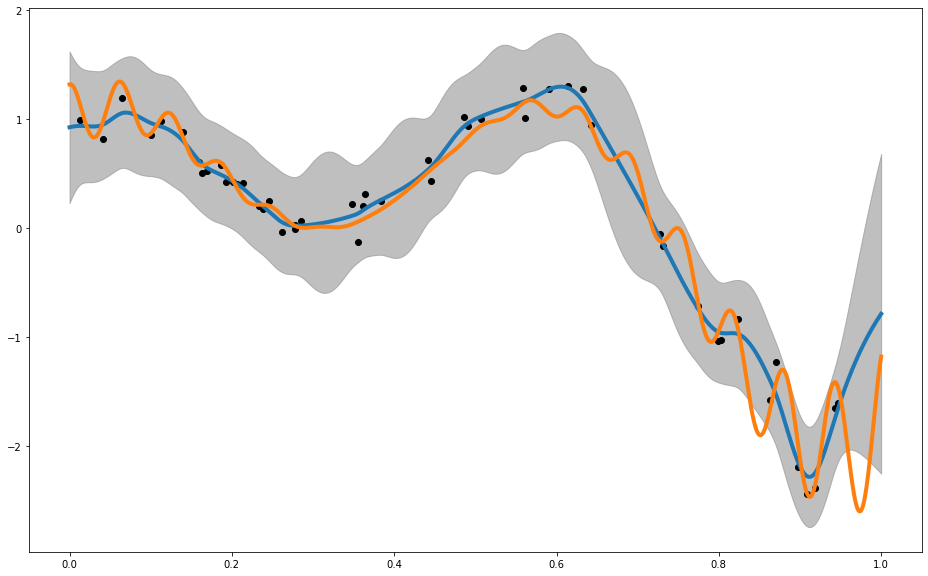

In [7]:
#let's make a prediction
x_pred = np.linspace(0,1,1000)

mean1 = my_gpo.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
var1 =  my_gpo.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]
plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x_pred1D,f1(x_pred1D), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
plt.scatter(x_data,y_data, color = 'black')


##looking at some validation metrics
print(my_gpo.rmse(x_pred1D,f1(x_pred1D)))
print(my_gpo.crps(x_pred1D,f1(x_pred1D)))

In [8]:
#available acquisition function:
acquisition_functions = ["variance","covariance","shannon_ig","shannon_ig_vec",
                        "ucb","lcb","maximum","minimum","gradient","expected_improvement",
                         "PI", "target_probability"]

Acquisition function  variance  creates an output of shape (1000,)
Acquisition function  covariance  creates an output of shape (1,)
Some acquisition function return a scalar score for the entirety of points. Here:  covariance
Acquisition function  shannon_ig  creates an output of shape (1,)
Some acquisition function return a scalar score for the entirety of points. Here:  shannon_ig
Acquisition function  shannon_ig_vec  creates an output of shape (1000,)
Acquisition function  ucb  creates an output of shape (1000,)
Acquisition function  lcb  creates an output of shape (1000,)
Acquisition function  maximum  creates an output of shape (1000,)
Acquisition function  minimum  creates an output of shape (1000,)
Acquisition function  gradient  creates an output of shape (1000,)
Acquisition function  expected_improvement  creates an output of shape (1000,)
Acquisition function  PI  creates an output of shape (1000,)
Acquisition function  target_probability  creates an output of shape (1000,)


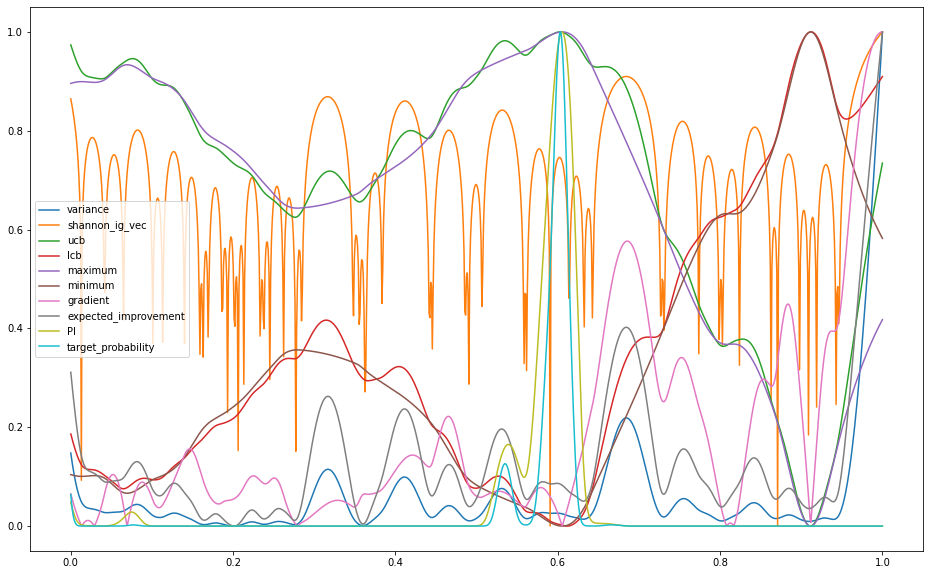

In [9]:
plt.figure(figsize=(16,10))
for acq_func in acquisition_functions:
    res = my_gpo.evaluate_acquisition_function(x_pred, acquisition_function=acq_func, 
                                args={'a': 1.5, 'b':2.} #this is only for acq_func = 'target_probability'
                                              )
    print("Acquisition function ",acq_func," creates an output of shape",res.shape)
    if len(res)==len(x_pred):
        res = res - np.min(res)
        res = res/np.max(res)
        plt.plot(x_pred,res, label = acq_func)
    else: print("Some acquisition function return a scalar score for the entirety of points. Here: ", acq_func)
plt.legend()
plt.show()


## Now let's see what the next best point to measure is
with several optimization methods and acquisition functions

In [ ]:
#let's test the asks:
bounds = np.array([[0.0,1.0]])
for acq_func in acquisition_functions:
    for method in ["global","local","hgdl"]:
        new_suggestion = my_gpo.ask(bounds, acquisition_function=acq_func, method=method)
        print("Acquisition function ", acq_func," led to new suggestion: \n", new_suggestion)
        print("using method ", method)
        print("")


In [ ]:
print(new_suggestion)
print(acquisition_functions[0])

In [35]:
x_test = np.array([[0.1],[0.1],[0.1],[10.8],[10.9]])
my_gpo.shannon_information_gain(x_test)

{'x': array([[ 0.1],
        [ 0.1],
        [ 0.1],
        [10.8],
        [10.9]]),
 'sig': inf}

In [37]:
#here we can test other options of the ask() command
bounds = np.array([[0.0,1.0]])
new_suggestion = my_gpo.ask(bounds, acquisition_function=acq_func, method="global",
                            max_iter=1000, n = 5, info = True)
print(new_suggestion)

shannon_ig
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
differential_evolution step 1: f(x)= 7.4266
differential_evolution step 2: f(x)= 7.4266
differential_evolution step 3: f(x)= 7.4266
differential_evolution step 4: f(x)= 7.11434
differential_evolution step 5: f(x)= 6.49368
differential_evolution step 6: f(x)= 6.49368
differential_evolution step 7: f(x)= 6.49368
differential_evolution step 8: f(x)= 6.49368
differential_evolution step 9: f(x)= 6.49368
differential_evolution step 10: f(x)= 6.49368
differential_evolution step 11: f(x)= 6.49368
differential_evolution step 12: f(x)= 6.49368
differential_evolution step 13: f(x)= 6.49368
differential_evolution step 14: f(x)= 6.49368
differential_evolution step 15: f(x)= 6.37525
differential_evolution step 16: f(x)= 6.37525
differential_evolution step 17: f(x)= 6.37525
differential_evolution step 18: f(x)= 6.37525
differential_evolution step 19: f(x)= 6.37525
differential_evolution step 20: f(x)= 6.37525
differential_evolution step 21: f(x

differential_evolution step 179: f(x)= -0.491927
differential_evolution step 180: f(x)= -0.491927
differential_evolution step 181: f(x)= -0.491927
differential_evolution step 182: f(x)= -0.491927
differential_evolution step 183: f(x)= -0.491927
differential_evolution step 184: f(x)= -0.491927
differential_evolution step 185: f(x)= -0.491927
differential_evolution step 186: f(x)= -0.491927
differential_evolution step 187: f(x)= -0.491927
differential_evolution step 188: f(x)= -1.14051
differential_evolution step 189: f(x)= -1.14051
differential_evolution step 190: f(x)= -1.14051
differential_evolution step 191: f(x)= -1.14051
differential_evolution step 192: f(x)= -1.95602
differential_evolution step 193: f(x)= -1.95602
differential_evolution step 194: f(x)= -1.95602
differential_evolution step 195: f(x)= -1.95602
differential_evolution step 196: f(x)= -1.95602
differential_evolution step 197: f(x)= -1.95602
differential_evolution step 198: f(x)= -2.5793
differential_evolution step 199:

differential_evolution step 369: f(x)= -inf
differential_evolution step 370: f(x)= -inf
differential_evolution step 371: f(x)= -inf
differential_evolution step 372: f(x)= -inf
differential_evolution step 373: f(x)= -inf
differential_evolution step 374: f(x)= -inf
differential_evolution step 375: f(x)= -inf
differential_evolution step 376: f(x)= -inf
differential_evolution step 377: f(x)= -inf
differential_evolution step 378: f(x)= -inf
differential_evolution step 379: f(x)= -inf
differential_evolution step 380: f(x)= -inf
differential_evolution step 381: f(x)= -inf
differential_evolution step 382: f(x)= -inf
differential_evolution step 383: f(x)= -inf
differential_evolution step 384: f(x)= -inf
differential_evolution step 385: f(x)= -inf
differential_evolution step 386: f(x)= -inf
differential_evolution step 387: f(x)= -inf
differential_evolution step 388: f(x)= -inf
differential_evolution step 389: f(x)= -inf
differential_evolution step 390: f(x)= -inf
differential_evolution step 391:

KeyboardInterrupt: 

In [19]:
#You can even start an ask() search asynchronously and check back later what was found
new_suggestion = my_gpo.ask(bounds, acquisition_function=acquisition_functions[0], method="hgdlAsync")
time.sleep(10)
print(new_suggestion["opt_obj"])
#And we have to cancel that trainig and possibly kill the client
new_suggestion["opt_obj"].kill_client()

variance
[[0. 1.]]


[{'x': array([0.31682415]),
  'f(x)': -0.02900315028939493,
  'classifier': 'minimum',
  'Hessian eigvals': array([75.61884452]),
  'df/dx': array([-1.50465196e-05]),
  '|df/dx|': 1.5046519585837359e-05,
  'radius': 0.013224216878145203},
 {'x': array([0.46606119]),
  'f(x)': -0.013016490898799526,
  'classifier': 'minimum',
  'Hessian eigvals': array([50.07716464]),
  'df/dx': array([1.09087184e-05]),
  '|df/dx|': 1.09087183730594e-05,
  'radius': 0.019969181706756364},
 {'x': array([0.59886625]),
  'f(x)': -0.009725499446896602,
  'classifier': 'minimum',
  'Hessian eigvals': array([11.16429171]),
  'df/dx': array([-4.23160396e-05]),
  '|df/dx|': 4.231603956128538e-05,
  'radius': 0.089571289041667}]